<link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Sofia">
<style>
  @import url('https://fonts.googleapis.com/css2?family=Concert+One&display=swap');
  .topic {
    text-align: center;
    font-weight: 900;
    font-size: 50px;
    text-shadow: 3px 3px 3px #ababab;
    font-family: 'Concert One', sans-serif;
  }
  @import url('https://fonts.googleapis.com/css2?family=Lobster&display=swap');
  .info {
    text-align: center;
    font-weight: 800;
    font-size: 40px;
    font-family: 'Lobster', sans-serif;
  }
</style>

<h1 class=topic>Google Analytics Customer Revenue Prediction</h1>
<h2 class=info>Vũ Minh Phát - 21127739</h2>

___

<class style="font-family: 'Comic Sans MS', 'Comic Sans', cursive;">

# **<u>Các thư viện cần sử dụng</u>**

</class>

In [1]:
# Import Section
import numpy as np
import pandas as pd
from pandas import json_normalize
import json
from zipfile import ZipFile
import tqdm
import datetime
import re

# Import matplotlib & seaborn for visualisation
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools

init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
%matplotlib inline

<class style="font-family: 'Comic Sans MS', 'Comic Sans', cursive;">

# **<u>Đọc dữ liệu từ file</u>**

</class>

## 4.1. Xây dựng hàm đọc dữ liệu

In [2]:
# ********** A USEFUL WAY TO READ VERY LARGE DATASETS COMPRESSED IN ZIP FILES **********
#
#   1.  After downloading the data from Kaggle, we will have a zip file
#           which contain our dataset in csv format.
#
#   2.  Because of (very) large size of the dataset, we will not extract the zip file
#           which help us to save our disk space.
#
#   3.  To read file csv in size the zip file, we will use ZipFile library.
#           so we need to define the path to the zip file.
#
#   4.  After that, we can use pandas to read the csv file like normal.
#
# Read more at: https://favtutor.com/blogs/zipfile-python#:~:text=How%20to%20read%20a%20zip,that%20we%20want%20to%20read.
# **************************************************************************************
ZIP_FILE_PATH = '../data/raw/ga-customer-revenue-prediction.zip'

In [3]:
def read_data_inside_zip_file(filename: str, zip_file_path: str = ZIP_FILE_PATH) -> pd.DataFrame:
    """Read the csv file inside the zip file
    
    Notes:
        zip_file_path is the path to the zip file containing the csv file

    Returns:
        pd.DataFrame: dataframe of 'filename' inside the zip file
    """
    with ZipFile(zip_file_path) as zf:      # Open the zip file with mode 'r'
        with zf.open(filename) as file:     # Open 'filename' inside the zip file
            df = pd.read_csv(file)          # Read data from 'filename'
                                            #   => Q: Why NOT set low_memory=False to solve DtypeWarning?
                                            #      A: Read at: https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

    return df

## 4.2. Đọc dữ liệu

In [4]:
# Read the data
train_df = read_data_inside_zip_file('train.csv')

/tmp/ipykernel_11373/1298650587.py:12: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



> Khi sử dụng `read_csv()` từ `Pandas`, thông báo `DtypeWarning` xuất hiện 
> đồng nghĩa với việc file dữ liệu có (ít nhất) 1 cột bao gồm nhiều kiểu dữ liệu (dtype).

Cột gây ra thông báo là:

In [5]:
# Columns (3) give DtypeWarning -> corresponding index is 3
print(f"=> Column give DtypeWarning: {train_df.columns[3]}")

=> Column give DtypeWarning: fullVisitorId


> Trong trường hợp này, cột `fullVisitorId` là nguyên nhân của thông báo trên. Ta sẽ quan sát toàn bộ dữ liệu đã đọc và tìm cách xử lý.

Ta xem một vài thông tin về tập dữ liệu:

In [6]:
train_df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


> * Dữ liệu có `903653 dòng` và `12 cột`:
>   * Mỗi dòng ứng với 1 phiên truy cập tới GStore từ người dùng.
>
>   * Mỗi cột tương ứng 1 thuộc tính đã được đề cập bên trên.
>
>   * Hơn thế nữa, ta không thấy `cell` nào bị thiếu dữ liệu.
>
> * Các cột: `device`, `geoNetwork`, `totals` và `trafficSource` 
> hiện đang lưu trữ dữ liệu dưới dạng `JSON` nên ta có thể 
> *"làm phẳng"* chúng để thuận tiện thao tác.

## 4.3. Đọc dữ liệu và làm phẳng

Ta có thể sử dụng đoạn code của [DATAISTA0 (JULIÁN PELLER)](https://www.kaggle.com/code/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook) để thực hiện việc này.

In [8]:
# From: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
def read_data_and_flatten(filename: str, nrows: int = None, 
                          zip_file_path: str = ZIP_FILE_PATH) -> pd.DataFrame:
    """Read the csv file inside the zip file and flatten json columns"""
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    with ZipFile(zip_file_path) as zf:
        with zf.open(filename) as file:
            df = pd.read_csv(file,
                             # Create JSON object for every json column
                             converters={col: json.loads for col in JSON_COLUMNS},
                             # Important!! Considering 'fullvisitor id as string'
                             dtype={'fullVisitorId': 'str'},
                             nrows=nrows)
            
    with tqdm.tqdm(total=len(JSON_COLUMNS)) as pbar:
        pbar.set_description(f"Flattening process")
        for column in JSON_COLUMNS:
            # json_normalize will return a flatten dataframe of json columns
            column_as_df = json_normalize(df[column])
            # Get column names
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            # Drop JSON columns and merge data frame with parsed columns
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
            
            pbar.update(1)
    
    print(f">> Loaded '{filename}' with shape: {df.shape}")
    return df

In [9]:
# Read the data
train_df = read_data_and_flatten('train.csv')

Flattening process: 100%|██████████| 4/4 [00:28<00:00,  7.01s/it]


>> Loaded 'train.csv' with shape: (903653, 55)


> Ta thấy tham số `dtype={'fullVisitorId': 'str'}` trong hàm `read_csv()` giúp
> thông báo `DtypeWarning` không còn xuất hiện.

Bây giờ ta sẽ quan sát dữ liệu sau khi biến đổi:

In [10]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

> * Hiện tai, dữ liệu được mở rộng thành `903653 dòng` và `55 cột`:
>   * Các cột: `device`, `geoNetwork`, `totals` và `trafficSource`
> đạ được tách thành các cột nhỏ hơn và có thể phân biệt thông
> qua ký hiệu `*.*`
>
>   * Tuy nhiên, `55 cột` là quá nhiều nên ta cần giảm bớt độ 
> rộng của dữ liệu.
>
>   **⇨** Ta quan sát thấy 1 vài `entry` bị thiếu dữ liệu và sẽ tìm cách xử lý.

## 4.4. Phân tích tổng quát kết quả

Các cột thiếu dữ liệu HOÀN TOÀN

In [12]:
cols_with_completely_missing = [col 
                                for col in train_df.columns 
                                if train_df[col].isnull().all()]
cols_with_completely_missing

[]

> Suy ra, không có cột nào hoàn toàn thiếu dữ liệu .
> Nghĩa là, không có cột nào chỉ chứa "giá trị" `NaN`.

Các cột chỉ có duy nhất 1 giá trị

In [13]:
cols_with_unique_value = [col 
                          for col in train_df.columns 
                          if train_df[col].nunique(dropna=True) == 1]
cols_with_unique_value

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

> * Trên lý thuyết, các cột chỉ có DUY NHẤT 1 giá trị (khác NaN) 
> thì cũng không có ý nghĩa gì khi dùng để dự đoán kết quả.
>
> * Do đó, ta có thể xóa các cột này để thu hẹp phạm vi dữ liệu.

Xóa các cột chỉ có 1 giá trị duy nhất

In [14]:
# Drop columns with unique value
train_df.drop(cols_with_unique_value, axis='columns', inplace=True)

Khi này dữ liệu còn lại:

In [15]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adContent
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,...,(not set),google,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,...,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 31 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               903653 non-null  object
 1   date                                          903653 non-null  int64 
 2   fullVisitorId                                 903653 non-null  object
 3   sessionId                                     903653 non-null  object
 4   visitId                                       903653 non-null  int64 
 5   visitNumber                                   903653 non-null  int64 
 6   visitStartTime                                903653 non-null  int64 
 7   device.browser                                903653 non-null  object
 8   device.operatingSystem                        903653 non-null  object
 9   device.isMobile                               903653 non-nu

> Khi này, số dòng không đổi nhưng dữ liệu chỉ còn `31 cột` và có 1 vài `entry` bị thiếu dữ liệu.

Ta lưu lại dữ liệu này để backup

In [17]:
train_df.to_csv('../data/processed/flat_reduced_train_.csv', index=False, na_rep='None')

In [40]:
# Đọc dữ liệu đã được làm phẳng và giảm số lượng cột (nếu cần)
train_df = pd.read_csv('../data/processed/flat_reduced_train_.csv', dtype={'fullVisitorId': 'str'})

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 31 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               903653 non-null  object 
 1   date                                          903653 non-null  int64  
 2   fullVisitorId                                 903653 non-null  object 
 3   sessionId                                     903653 non-null  object 
 4   visitId                                       903653 non-null  int64  
 5   visitNumber                                   903653 non-null  int64  
 6   visitStartTime                                903653 non-null  int64  
 7   device.browser                                903653 non-null  object 
 8   device.operatingSystem                        903653 non-null  object 
 9   device.isMobile                               90

___

Ta phân tích tình trạng thiếu dữ liệu của các cột còn lại

In [42]:
# From: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset

# Check how much percentage of missing data in each colummn:
percent_missing = train_df.isnull().sum() * 100 / train_df.shape[0]
missing_value_df = pd.DataFrame({'column_name': train_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.reset_index(drop=True, inplace=True)
missing_value_df.sort_values(by='percent_missing', ascending=False)

,column_name,percent_missing
30,trafficSource.adContent,98.788694
20,totals.transactionRevenue,98.725728
26,trafficSource.adwordsClickInfo.page,97.625195
27,trafficSource.adwordsClickInfo.slot,97.625195
29,trafficSource.adwordsClickInfo.adNetworkType,97.625195
28,trafficSource.adwordsClickInfo.gclId,97.614018
25,trafficSource.referralPath,63.377425
24,trafficSource.keyword,55.655102
19,totals.pageviews,0.011066
1,date,0.000000


Ta có thể biễu diễn dưới dạng đồ thị để dễ quan sát hơn

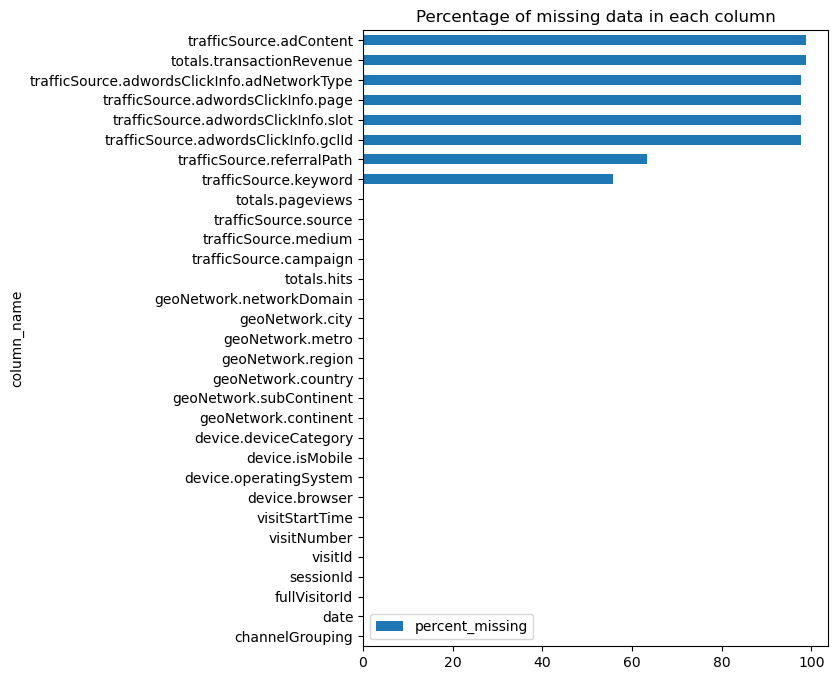

In [43]:
missing_value_df.sort_values(by='percent_missing', ascending=True)\
                    .plot.barh(x='column_name',
                               y='percent_missing',
                               figsize=(6, 8),
                               title='Percentage of missing data in each column');

## 4.5. Phân tích cụ thể từng cột bị thiếu giá trị

* `totals.transactionRevenue`

Ta xem các giá trị có trong cột này

In [44]:
train_df['totals.transactionRevenue'].describe()

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [45]:
train_df['totals.transactionRevenue'].unique()

array([       nan, 3.7860e+07, 3.0667e+08, ..., 3.3526e+08, 3.0750e+07,
       6.9390e+07])

> Cột này thể hiện tổng giá trị giao dịch trong phiên nên ta chỉ cần 
> thay các giá trị `NaN` bằng `0`.

Điền giá trị `0` vào các entry bị trống

In [46]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)

* Các cột bị thiếu nhiều dữ liệu

Các thuộc tính bị thiếu quá nhiều dữ liệu (trừ giá trị mục tiêu) thường không quá hữu ích khi dùng trong phân tích. Với từng tập dữ liệu khác nhau thì ngưỡng đặt ra cũng khác nhau. Thông thường, nếu 1 cột có hơn `75%` dữ liệu bị thiếu thì đây cột này được xem là thiếu dữ liệu trầm trọng ta sẽ ưu tiên loại bỏ nó khỏi tập dữ liệu.

In [47]:
def drop_missing_features(df: pd.DataFrame, missing_lst: dict, threshold: float = 75.0) -> pd.DataFrame:
    """Drop missing features from Pandas dataframe base on given threshold.

    Args:
        df (pd.DataFrame): Input dataframe for processing.
        missing_lst (dict, optional): Dict missing value rate which calculated from previous stage. Defaults to dict(num_col_info_df.iloc[0]).
        threshold (float, optional): User threshold for dropping. Defaults to 75.0.

    Returns:
        pd.DataFrame: Updated dataframe
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    if (df is None) or (missing_lst is None) or (threshold is None):
        print(f"[LOG] Invalid.")
        raise ValueError
    
    # Create a copy of the dataframe to avoid changing the original
    df_cp = df.copy()
    
    # List to maintain the columns to drop
    cols_to_trim = []
    
    for key, value in missing_lst.items():
        if float(value) > threshold:
            cols_to_trim.append(key)
            
    if len(cols_to_trim) > 0:
        # drop the columns identified using the dataframe drop() method
        df_cp = df_cp.drop(columns=cols_to_trim)
        print("[LOG] Dropped column(s): " + "\n + ".join([""]+cols_to_trim))
    else:
        print("[LOG] Have no column(s) to trim.")
        
    return df_cp

In [48]:
train_df.shape

(903653, 31)

In [49]:
train_df = drop_missing_features(
    train_df, 
    {col_name: percent_missing
     for col_name, percent_missing in zip(missing_value_df['column_name'],
                                          missing_value_df['percent_missing'])}
)

[LOG] Dropped column(s): 
 + totals.transactionRevenue
 + trafficSource.adwordsClickInfo.page
 + trafficSource.adwordsClickInfo.slot
 + trafficSource.adwordsClickInfo.gclId
 + trafficSource.adwordsClickInfo.adNetworkType
 + trafficSource.adContent


In [50]:
train_df.shape

(903653, 25)

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   channelGrouping             903653 non-null  object 
 1   date                        903653 non-null  int64  
 2   fullVisitorId               903653 non-null  object 
 3   sessionId                   903653 non-null  object 
 4   visitId                     903653 non-null  int64  
 5   visitNumber                 903653 non-null  int64  
 6   visitStartTime              903653 non-null  int64  
 7   device.browser              903653 non-null  object 
 8   device.operatingSystem      903653 non-null  object 
 9   device.isMobile             903653 non-null  bool   
 10  device.deviceCategory       903653 non-null  object 
 11  geoNetwork.continent        903653 non-null  object 
 12  geoNetwork.subContinent     903653 non-null  object 
 13  geoNetwork.cou